In [112]:
import numpy as np
import math as math

# physical constants in cgs units
c = 29979245800 # cm/s
h = 6.62507015 / (10**41) # erg s
k_B = 1.380649 / (10**30) # erg/K
R_sun = 6.96 * (10**10) # cm
pc = 3.08567758 * (10**18) # cm

def abs_coeff_r(T, nu, n_0, r):
    """calculates the absorption coefficient alpha_nu that is dependent on r through the relation n = n_0*r^-2.
    For fully ionized hydrogen, n_e = n_i & Z=1
    T = temperature
    nu = frequency
    n_0 = initial number density profile
    r = distance to absorption (from observer?) => variable
    """
    C = 3.692 * (10**8)  # the  number in front of the expression
    BB = 1 - np.exp(-(h * nu) / (k_B * T))  # term found in the blackbody spectrum
    g = (
        10.6 + 1.9 * np.log10(T) + 1.26 * np.log10(nu)
    )  # Gaunt factor
    return (C * BB * g * (n_0**2)) / (np.sqrt(T) * (nu**3) * 4 * (r**4))

def abs_coeff_n(T, nu, n):
    """calculates the absorption coefficient alpha_nu that is dependent on n through the relation n = 2*n_e.
    T = temperature
    nu = frequency
    n = calculated number density profile value
    """
    C = 3.692 * (10**8)  # the  number in front of the expression
    BB = 1 - np.exp(-(h * nu) / (k_B * T))  # term found in the blackbody spectrum
    g = (
        10.6 + 1.9 * np.log10(T) + 1.26 * np.log10(nu)
    )  # Gaunt factor
    return C * BB * g * ((n**2)/(np.sqrt(T)*(nu**3)*4))

In [113]:
# example values from Kavanagh et al. (2020)
T = 10**6  # K
nu = 10 ** 8 # Hz = 100 MHz
n_0 = 10**8  # cm^-3

example_value = abs_coeff_r(T, nu, n_0, R_sun)
print(example_value)

6.05489063569352e-54


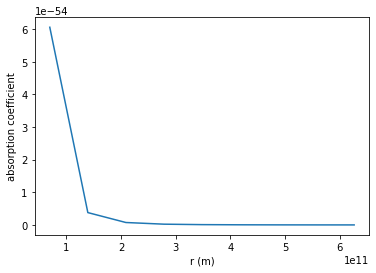

In [114]:
#plot a alpha_nu - r diagram
import matplotlib.pyplot as plt

r_list = [(x*R_sun) for x in range(1, 10)]
alpha_nu_list = [abs_coeff_r(T, nu, n_0, y) for y in r_list]
#print(alpha_nu_list)

#just to check the shape of the function
a_r = plt.subplot()
a_r.plot(r_list, alpha_nu_list)
a_r.set_xlabel("r (m)")
a_r.set_ylabel("absorption coefficient")
plt.show()

The absorption coefficient (AC) was derived using the density profile which decreases as r^-2. While calculating the AC, I used astropy units to see the resulting units of the AC. However, I'm not sure if these are the right units as I have left the Gaunt factor to be dimensionless (the code doesn't compute the log of a dimensionful variable). 

The plot makes sense as r^-4, but plots for any r really as I don't know what values the AC should be/is expected to be. 

In [115]:
def opt_depth(d):
    """calculate the optical depth given a radius from which the absorption coefficient is obtained.
    d = distance to absorption, from observer
    """
    #take 20 steps, for instance
    #taking d to be up to the position of the planet
    dr = d/20
    dr_array = np.arange(1, d, dr)
    tau_nu = 0

    # for each dr, calculate and add up d\tau at the r+dr position
    for r in dr_array:
        #print(r)
        alpha_nu = abs_coeff_r(T, nu, n_0, r)
        tau_nu += alpha_nu*dr
    
    return tau_nu

The method I use in calculating the optical depth (OD) is by summing all the contributions from each new r + dr times the AC at that r.

In [116]:
example_OD = opt_depth(pc)
print(example_OD)

21921174.088152245


In [117]:
# constant in cgs units
au = 1.49597871 * (10**13) # cm

def dens_profile(r):    # calculate the density profile which goes as r^-2
    return n_0/(r**2)

#2D grid
L_grid = 100
wind_coordinate_system = np.linspace((-0.03*au, -0.03*au), (0.03*au, 0.03*au), L_grid) # axes of x & y, this is not a 2d grid!

# here we fill the grid with the corresponding number density at position (x,y)
# now using numpy meshgrid, was originally two for loops which is very inefficient
x, y = np.meshgrid(wind_coordinate_system[:, 0], wind_coordinate_system[:, 1], indexing='ij')
r = (x**2 + y**2)**0.5 # 2d grid with r vector
n = dens_profile(r) # 2d grid with number density profile


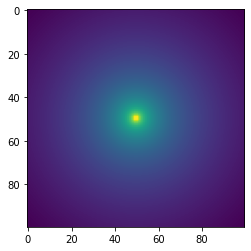

In [118]:
from matplotlib.colors import LogNorm

#log normalized plot of a slice of the wind
plt.imshow(n, norm=LogNorm())

Above, I have made a 2D grid of coordinates x & y. The center of the wind is taken as the origin of the grid. This grid took inspiration from the right figure in fig. 2 in Kavanagh et al. (2020). The density profile is calculated using n = n_0 * r^-2 and r is simply the direct distance from the origin to point (x,y). I might make a color diagram to see if the density profile is symmetrically (and thus correctly) distributed from the origin over the grid.

Here is the important part: r in the number density is taken as a radius with origin of the wind. d in the optical depth is the distance where the observer's position is the origin. This distance d is defined along the line of sight which is what we use to determine the OD of this grid in the following note/block.